In [1]:
%load_ext autoreload
%autoreload 2
from clearmap_viz.graph_utils import load_graph
from nb_modules.params import DISTANT_DATA_FOLDER
from pathlib import Path
from nb_modules.experimental import create_skeleton_map
from clearmap_viz.visualization import *
from clearmap_viz.graph_utils import Graph
from skimage.measure import regionprops
from napari.utils.colormaps import DirectLabelColormap
import napari


colormap_purple = DirectLabelColormap(color_dict={
    0: np.array([0, 0, 0, 0]),
    1: np.array([1, 0, 1, 1]),
    None: np.array([0, 0, 0, 1]),
    })

colormap_green = DirectLabelColormap(color_dict={
    0: np.array([0, 0, 0, 0]),
    1: np.array([0, 1, 0, 1]),
    None: np.array([0, 0, 0, 1]),
    })

scale_projection = (62.5, 1.625, 1.625) # 62.5 is 25 * 2.5
scale_full_res = (2.5, 1.625, 1.625)

2024-05-21 12:13:31 [INFO] ClearMap not accessible. Appending ClearMap local path.


In [2]:
def bbox_to_slices(bbox:tuple[int]) -> tuple[slice]:
    """
    Convert a 3D bounding box (as the skimage.regionprops bbox attribute) to slices (tuple of 3 slice objects).
    """
    return (slice(bbox[0], bbox[3]), slice(bbox[1], bbox[4]),  slice(bbox[2], bbox[5]),)

def scale_bbox(bbox:tuple[int], scale_source:tuple[int]|np.ndarray, scale_target:tuple[int]|np.ndarray) -> tuple[int]:
    """
    Scale a 3D bounding box from one scale to another.
    """
    bbox = np.array(bbox) # bbox is tuple(x1, y1, z1, x2, y2, z2)
    scale_source = np.tile(scale_source, 2) # repeat scale so that shape corresponds to bbox
    scale_target = np.tile(scale_target, 2) # repeat scale so that shape corresponds to bbox
    bbox = (bbox * scale_source / scale_target).astype(int)
    return tuple(bbox)

# Load graph and generate skeleton projection

In [3]:
SAMPLE_NAME = "Ge1141"
graph_path = DISTANT_DATA_FOLDER / SAMPLE_NAME / f"vascular-graphs/{SAMPLE_NAME}_graph_v03.gt"
g = load_graph(graph_path)
g.compute_dfs(with_eg_df=True)
skeleton_map = create_skeleton_map(SAMPLE_NAME, g, 25)

Filling the skeleton map ...


In [5]:
napari.Viewer(title="Whole sample")

# display mip
view_img(DISTANT_DATA_FOLDER / SAMPLE_NAME / f"{SAMPLE_NAME}_CD31-corrected_mip_50_50_25.npy", name="CD31", colormap="gray", blending="additive", scale=scale_projection)

# display skeleton
view_labels(skeleton_map.swapaxes(0, 2), name="graph_skeleton", colormap=colormap_purple, blending="translucent", opacity=0.5, scale=scale_projection)

# add an empty labels layer
layer_name = "labels"
labels = np.zeros_like(skeleton_map.swapaxes(0, 2), dtype=np.uint8)
view_labels(labels, name=layer_name, colormap=colormap_green, blending="translucent", opacity=0.5, scale=scale_projection)

Viewer(camera=Camera(center=(0.0, 2114.125, 1946.75), zoom=0.11104367715538059, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1500.0, 1.0, 0.0), scaled=True, size=16, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 3250.0, 125.0), (0.0, 4229.875, 1.625), (0.0, 3895.125, 1.625)), current_step=(12, 1301, 1198), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'CD31' at 0x7f1da741aad0>, <Labels layer 'graph_skeleton' at 0x7f1dc12c2950>, <Labels layer 'labels' at 0x7f1d9c963c10>], help='use <1> for activate the label eraser, use <2> for activate the paint brush, use <3> for activate the fill bucket, use <4> for pick mode', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='Whole sample', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_call

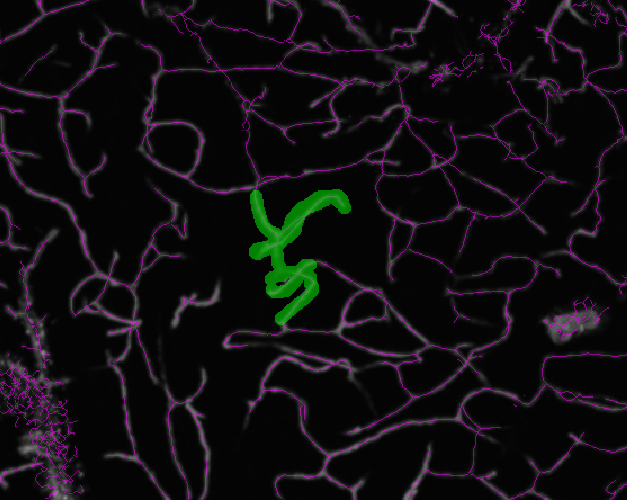
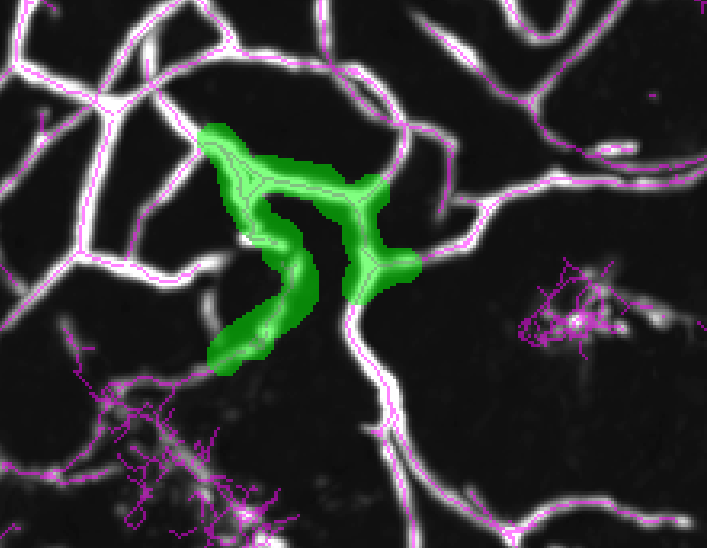

# Retrieve labels

In [6]:
layer_name = "labels"
labels = get_labels(layer_name=layer_name)

# Visualize the bounding box of the ROI

In [7]:
regions = regionprops(labels)

In [8]:
assert len(regions) == 1, "There should be only one region in the labels layer"
# Creates a bounding box for the first region and scales it to full resolution
bbox = regions[0].bbox
bbox_full_res = scale_bbox(bbox, scale_projection, scale_full_res)
# Creates slices from the bounding box
slicing = bbox_to_slices(bbox)
slicing_full_res = bbox_to_slices(bbox_full_res)
bbox, bbox_full_res, slicing, slicing_full_res

((16, 1429, 679, 20, 1661, 776),
 (400, 1429, 679, 500, 1661, 776),
 (slice(16, 20, None), slice(1429, 1661, None), slice(679, 776, None)),
 (slice(400, 500, None), slice(1429, 1661, None), slice(679, 776, None)))

In [9]:
# Creates a viewer with only the region of interest
v2 = napari.Viewer(title="Region of interest")

# Display the mip
view_img(DISTANT_DATA_FOLDER / SAMPLE_NAME / f"{SAMPLE_NAME}_CD31-corrected_mip_50_50_25.npy", name="CD31",  viewer=v2, slicing=slicing, colormap="gray", blending="additive", scale=scale_projection)
# Display the skeleton
view_labels(skeleton_map.swapaxes(0, 2), name="graph_skeleton",  viewer=v2, slicing=slicing, colormap=colormap_purple, blending="translucent", opacity=0.5, scale=scale_projection)
# Display the labels
view_labels(labels,  viewer=v2, slicing=slicing, colormap=colormap_green, blending="translucent", opacity=0.5, scale=scale_projection)

Viewer(camera=Camera(center=(0.0, 187.6875, 78.0), zoom=1.2458909122217916, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(62.5, 1.0, 0.0), scaled=True, size=16, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 250.0, 62.5), (0.0, 377.0, 1.625), (0.0, 157.625, 1.625)), current_step=(1, 115, 48), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'CD31' at 0x7f1d8e673d10>, <Labels layer 'graph_skeleton' at 0x7f1d8e65fb50>, <Labels layer 'Labels' at 0x7f1d8e643dd0>], help='use <1> for activate the label eraser, use <2> for activate the paint brush, use <3> for activate the fill bucket, use <4> for pick mode', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='Region of interest', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], 

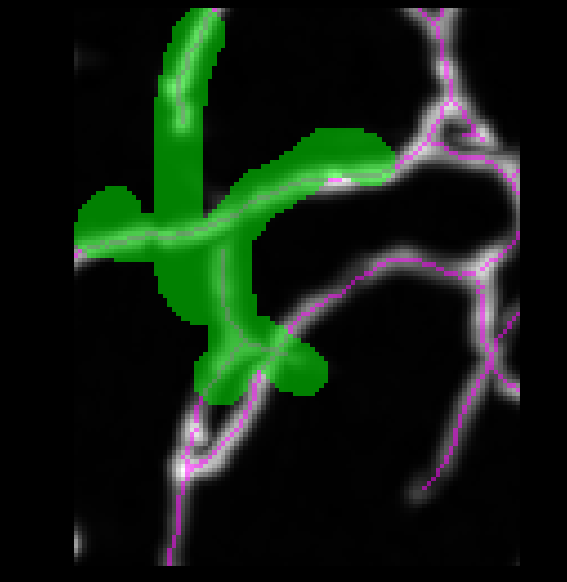
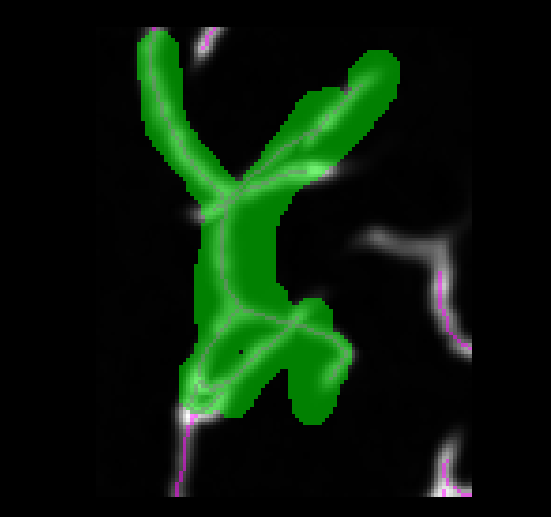
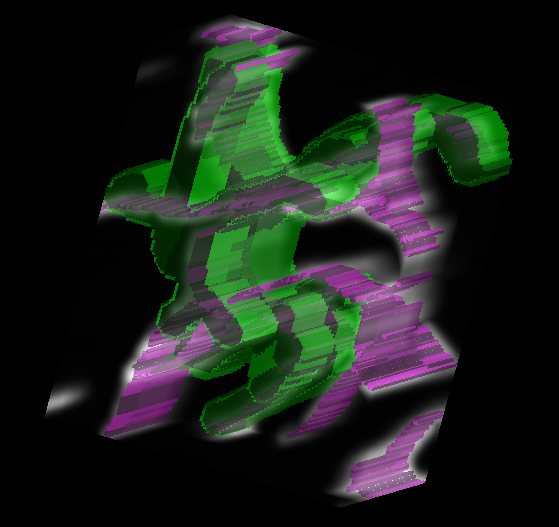

In [10]:
# Display the full resolution image

v2.dims.ndisplay = 2 # ensures viewer is in 2d mode
view_img(DISTANT_DATA_FOLDER / SAMPLE_NAME / f"{SAMPLE_NAME}_CD31-corrected.npy", name="CD31 full res",  viewer=v2, slicing=slicing_full_res, colormap="orange", blending="additive", scale=scale_full_res)

Viewer(camera=Camera(center=(0.0, 187.6875, 78.0), zoom=1.2458909122217916, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(-27.5, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((-30.0, 250.0, 2.5), (0.0, 377.0, 1.625), (0.0, 157.625, 1.625)), current_step=(1, 115, 48), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'CD31' at 0x7f1d8e673d10>, <Labels layer 'graph_skeleton' at 0x7f1d8e65fb50>, <Labels layer 'Labels' at 0x7f1d8e643dd0>, <Image layer 'CD31 full res' at 0x7f1d8e6e2c50>], help='use <2> for transform', status='', tooltip=Tooltip(visible=False, text=''), theme='dark', title='Region of interest', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f1daab88680>], _per

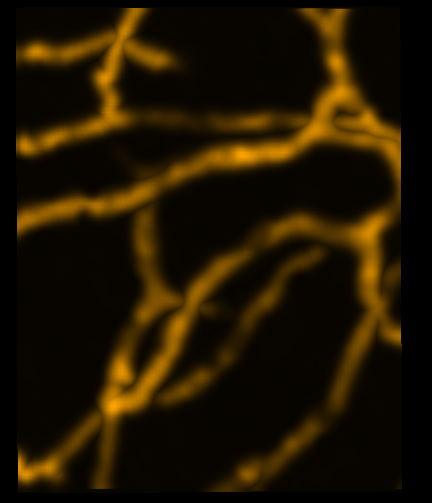

# Select a subpart of the graph

In [27]:
labels_clearmap = labels.swapaxes(0, 2)

# aim is to find the edges that are within the region of interest

# find edge geometries that are within the region of interest
coords_df = g.eg_df[["x", "y", "true_z",]].astype(int)
mask = ((coords_df > 0) & (coords_df < labels_clearmap.shape)).all(axis=1)
coords = tuple(coords_df[mask].values.T)
g.eg_df["in_label"] = 0
g.eg_df.loc[mask, "in_label"] = (labels_clearmap[coords] == 1).astype(int)

display(g.eg_df.in_label.sum(), g.eg_df.in_label.mean()*100)
display(g.eg_df.query("in_label == 1").sample(5, random_state=0, replace=True))

# select the edges that have one edge_geometry within the region of interest
edge_mask = np.isin(g.e_df.index, g.eg_df.query("in_label == 1").edge_index.values)

display(edge_mask.sum(), edge_mask.mean()*100)
display(g.e_df[edge_mask].sample(5, random_state=0, replace=True))

# select the vertices that have one edge within the region of interest
vertex_mask = np.isin(g.v_df.index, g.e_df.loc[edge_mask, ["starting_vertex", "ending_vertex"]].values) 

display(vertex_mask.sum(), vertex_mask.mean()*100)
display(g.v_df[vertex_mask].sample(5, random_state=0, replace=True))

69

0.002017240683710109

,x,y,z,radii,edge_index,true_z,in_label
2784844,705.000000,1660.000000,408.000000,4.242641,228846,16,1
2784847,701.666667,1658.666667,411.333333,4.242641,228846,16,1
2835121,696.000000,1649.000000,422.000000,5.099020,233149,16,1
2835124,694.000000,1646.000000,423.000000,5.385165,233149,16,1
2835124,694.000000,1646.000000,423.000000,5.385165,233149,16,1


11

0.0038221916446890642

,starting_vertex,ending_vertex,component,starting_degree,ending_degree,starting_x,starting_y,starting_z,ending_x,ending_y,...,ep_length,ep_radii,ep_edge_geometry_indices,ep_radii_um,ep_length_um,ep_distance_um,ep_tortuosity,ep_x_axis_angle,ep_y_axis_angle,ep_z_axis_angle
114962,109028,204810,0,3,4,743.000000,1524.000000,495.000000,747.250000,1515.250000,...,8.0,6.782330,"[1386936, 1386945]",12.723146,24.403303,21.791492,1.114739,71.522988,49.270332,46.500991
92544,87434,91296,0,1,3,710.000000,1617.000000,415.000000,711.000000,1622.000000,...,15.0,7.348469,"[1146862, 1146878]",13.785181,43.905708,38.404508,1.140274,87.574935,77.785995,12.459737
96502,91296,101252,0,3,3,711.000000,1622.000000,430.000000,733.000000,1566.000000,...,60.0,8.544004,"[1191152, 1191213]",16.027914,166.097316,132.887405,1.248970,74.393758,46.780886,47.369705
96502,91296,101252,0,3,3,711.000000,1622.000000,430.000000,733.000000,1566.000000,...,60.0,8.544004,"[1191152, 1191213]",16.027914,166.097316,132.887405,1.248970,74.393758,46.780886,47.369705
228846,190023,190926,0,3,3,704.666667,1662.333333,405.666667,701.666667,1658.666667,...,5.0,5.385165,"[2784842, 2784848]",10.102168,17.906183,16.123331,1.103730,72.400782,68.312300,28.520791


13

0.005767754701829266

,x,y,z,degree,component,connected_edges,vp_coordinates,vp_radii,vp_distance_to_surface_um,vp_coordinates_um,...,vp_n_hop_1_neighbors,vp_n_hop_2_neighbors,vp_n_hop_3_neighbors,vp_n_hop_4_neighbors,vp_n_hop_5_neighbors,vp_n_hop_6_neighbors,vp_n_hop_7_neighbors,vp_n_hop_8_neighbors,vp_n_hop_9_neighbors,vp_n_hop_10_neighbors
204810,747.250000,1515.250000,501.000000,4,0,"[253827, 253828, 114962, 116594]","[747.25, 1515.25, 501.0]",5.385165,338,"[1214.28125, 2462.28125, 1252.5]",...,5,9,13,17,21,25,34,45,60,81
109028,743.000000,1524.000000,495.000000,3,0,"[114961, 114962, 106918]","[743.0, 1524.0, 495.0]",6.403124,349,"[1207.375, 2476.5, 1237.5]",...,4,9,13,17,21,27,35,49,67,90
87434,710.000000,1617.000000,415.000000,1,0,[92544],"[710.0, 1617.0, 415.0]",1.000000,480,"[1153.75, 2627.625, 1037.5]",...,2,4,8,12,19,27,38,53,72,98
91296,711.000000,1622.000000,430.000000,3,0,"[96502, 92544, 96274]","[711.0, 1622.0, 430.0]",7.280110,453,"[1155.375, 2635.75, 1075.0]",...,4,8,12,19,27,38,53,72,98,137
195308,674.666667,1635.333333,441.333333,3,0,"[237639, 237640, 233149]","[674.6666666666666, 1635.3333333333333, 441.33...",2.236068,394,"[1096.3333333333333, 2657.4166666666665, 1103....",...,4,8,16,28,45,69,104,165,247,365


# Display the subgraph 

In [12]:
sg = g.sub_graph(vertex_mask)
sg = (Graph(sg))
sg.compute_dfs(with_eg_df=True)

Graph[13·][12-]|G|

In [13]:
import ClearMap.Analysis.Graphs.GraphRendering as gr

edge_colors = np.tile([1., 0, 1, 1], (sg.n_edges, 1)) * np.random.random(sg.n_edges).reshape(-1, 1)
interpolation = gr.interpolate_edge_geometry(sg, smooth=5, order=2, points_per_pixel=0.2, verbose=False)

coordinates, faces, colors = gr.mesh_tube_from_coordinates_and_radii(*interpolation,
                                        n_tube_points=5, edge_colors=edge_colors,
                                        processes=None, verbose=False)

In [14]:
v3 = napari.Viewer(title="Vascular graph")
v3.add_surface((coordinates, faces), name="graph_surface", )
v3.dims.ndisplay = 3

# Wip zone

In [92]:
coordinates.shape, faces.shape, colors.shape

((375, 3), (550, 3), (375, 4))

In [86]:
sg.vertex_property("coordinates").min(axis=0), sg.vertex_property("coordinates").max(axis=0)

(array([1377.33333333,  724.33333333,  334.        ]),
 array([1472.,  796.,  403.]))

In [20]:
len(sg.edge_geometry_property("coordinates"))

226

In [21]:
sg.eg_df

,x,y,z,radii,edge_index
0,710.000000,1617.000000,415.000000,1.000000,0
1,710.000000,1618.000000,416.000000,1.000000,0
2,711.000000,1619.000000,417.000000,1.000000,0
3,711.000000,1619.000000,418.000000,1.414214,0
4,710.000000,1620.000000,419.000000,1.000000,0
...,...,...,...,...,...
221,679.000000,1637.000000,437.000000,2.236068,11
222,678.000000,1636.000000,438.000000,2.449490,11
223,677.000000,1635.000000,439.000000,3.162278,11
224,676.000000,1635.000000,440.000000,2.828427,11


In [22]:
sg.e_df

,starting_vertex,ending_vertex,component,starting_degree,ending_degree,starting_x,starting_y,starting_z,ending_x,ending_y,...,ep_length,ep_radii,ep_edge_geometry_indices,ep_radii_um,ep_length_um,ep_distance_um,ep_tortuosity,ep_x_axis_angle,ep_y_axis_angle,ep_z_axis_angle
0,0,3,0,1,3,710.000000,1617.000000,415.000000,711.000000,1622.000000,...,15.0,7.348469,"[0, 16]",13.785181,43.905708,38.404508,1.140274,87.574935,77.785995,12.459737
1,1,9,0,1,3,705.000000,1665.000000,419.000000,700.666667,1660.000000,...,5.0,3.741657,"[16, 22]",7.019070,14.170908,12.232272,1.149091,54.853922,48.376982,61.518132
2,2,10,0,2,3,714.000000,1625.000000,429.000000,697.666667,1650.333333,...,25.0,8.544004,"[22, 48]",16.027914,62.143038,51.739079,1.198768,59.136755,37.282451,71.208263
3,2,3,0,2,3,714.000000,1625.000000,429.000000,711.000000,1622.000000,...,3.0,7.280110,"[48, 52]",13.656944,7.991964,7.333570,1.075118,48.336754,48.336754,70.068400
4,3,4,0,3,2,711.000000,1622.000000,430.000000,733.000000,1566.000000,...,60.0,8.544004,"[52, 113]",16.027914,166.097316,132.887405,1.248970,74.393758,46.780886,47.369705
5,4,5,0,2,2,733.000000,1566.000000,466.000000,743.000000,1524.000000,...,43.0,7.874008,"[113, 157]",14.771052,116.776747,100.887933,1.156344,80.731003,47.429787,44.059408
6,5,12,0,2,1,743.000000,1524.000000,495.000000,747.250000,1515.250000,...,8.0,6.782330,"[157, 166]",12.723146,24.403303,21.791492,1.114739,71.522988,49.270332,46.500991
7,6,8,0,1,3,696.333333,1650.666667,397.666667,701.666667,1658.666667,...,14.0,5.744563,"[166, 181]",10.776371,45.576259,37.569565,1.209896,76.662703,69.755636,24.574117
8,7,8,0,1,3,704.666667,1662.333333,405.666667,701.666667,1658.666667,...,5.0,5.385165,"[181, 187]",10.102168,17.906183,16.123331,1.103730,72.400782,68.312300,28.520791
9,8,9,0,3,3,701.666667,1658.666667,411.333333,700.666667,1660.000000,...,4.0,4.242641,"[187, 192]",7.958878,14.223226,13.605618,1.037766,83.140449,80.836753,11.481991


In [23]:
sg.v_df

,x,y,z,degree,component,connected_edges,vp_coordinates,vp_radii,vp_distance_to_surface_um,vp_coordinates_um,...,vp_n_hop_1_neighbors,vp_n_hop_2_neighbors,vp_n_hop_3_neighbors,vp_n_hop_4_neighbors,vp_n_hop_5_neighbors,vp_n_hop_6_neighbors,vp_n_hop_7_neighbors,vp_n_hop_8_neighbors,vp_n_hop_9_neighbors,vp_n_hop_10_neighbors
0,710.000000,1617.000000,415.000000,1,0,[0],"[710.0, 1617.0, 415.0]",1.000000,480,"[1153.75, 2627.625, 1037.5]",...,2,4,8,12,19,27,38,53,72,98
1,705.000000,1665.000000,419.000000,1,0,[1],"[705.0, 1665.0, 419.0]",3.741657,449,"[1145.625, 2705.625, 1047.5]",...,4,8,15,25,37,51,68,93,123,166
2,714.000000,1625.000000,429.000000,2,0,"[2, 3]","[714.0, 1625.0, 429.0]",5.916080,456,"[1160.25, 2640.625, 1072.5]",...,4,8,14,22,34,49,68,94,130,192
3,711.000000,1622.000000,430.000000,3,0,"[4, 0, 3]","[711.0, 1622.0, 430.0]",7.280110,453,"[1155.375, 2635.75, 1075.0]",...,4,8,12,19,27,38,53,72,98,137
4,733.000000,1566.000000,466.000000,2,0,"[5, 4]","[733.0, 1566.0, 466.0]",7.000000,398,"[1191.125, 2544.75, 1165.0]",...,4,8,13,17,23,31,42,57,79,108
5,743.000000,1524.000000,495.000000,2,0,"[6, 5]","[743.0, 1524.0, 495.0]",6.403124,349,"[1207.375, 2476.5, 1237.5]",...,4,9,13,17,21,27,35,49,67,90
6,696.333333,1650.666667,397.666667,1,0,[7],"[696.3333333333334, 1650.6666666666667, 397.66...",5.099020,495,"[1131.5416666666667, 2682.3333333333335, 994.1...",...,4,9,17,29,40,53,69,90,120,169
7,704.666667,1662.333333,405.666667,1,0,[8],"[704.6666666666666, 1662.3333333333333, 405.66...",3.162278,479,"[1145.0833333333333, 2701.2916666666665, 1014....",...,4,10,16,25,37,50,65,84,112,146
8,701.666667,1658.666667,411.333333,3,0,"[9, 7, 8]","[701.6666666666666, 1658.6666666666667, 411.33...",4.242641,466,"[1140.2083333333333, 2695.3333333333335, 1028....",...,4,10,20,30,42,57,75,98,129,178
9,700.666667,1660.000000,416.666667,3,0,"[10, 1, 9]","[700.6666666666666, 1660.0, 416.6666666666667]",3.741657,454,"[1138.5833333333333, 2697.5, 1041.6666666666667]",...,4,10,19,30,43,60,82,109,149,217


In [ ]:
sg.plot_radii()

In [184]:
from clearmap_viz.graph_viz import plot_pyvista

In [ ]:
plot_pyvista(g, edge_colors)

In [ ]:
g.plot_edge_value(g, "in_label", digitize=False)

In [ ]:
g.plot_radii()

In [6]:
from ClearMap.Analysis.Graphs.GraphRendering import interpolate_edge_geometry

In [ ]:
interpolate_edge_geometry(g, processes=1, verbose=True)

In [ ]:
g.plot_components()